In [1]:
# Обработка данных
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# ml-algorithms
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# MNIST dataset
from sklearn.datasets import load_digits
digits_df = load_digits()
digits_features = digits_df['data']
digits_labels = digits_df['target']

# Модуль с ф-циями, которые я написал для удобства
from extra_modules import tools

In [2]:
from importlib import reload
reload(tools)

<module 'extra_modules.tools' from '/home/vsevolod/Documents/python_stuff/mnist-generation-experiments/extra_modules/tools.py'>

## Посмотрим на различные визуализации опорных векторов

Посмотрим за что отвечают компоненты в PCA, натренированные только на 0

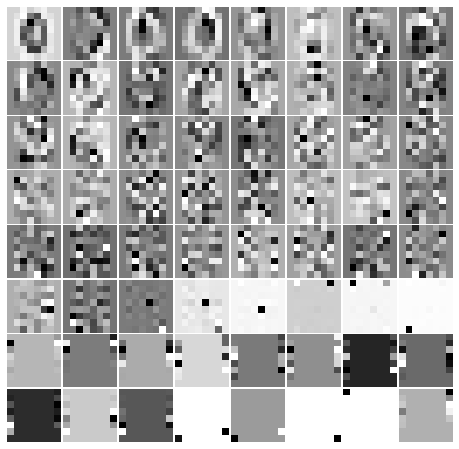

In [3]:
X_zeros = digits_features[digits_labels == 0]
pca = PCA(n_components=64)
pca.fit(X_zeros)
tools.display_rows_as_images(pca.components_);

А теперь на всех данных

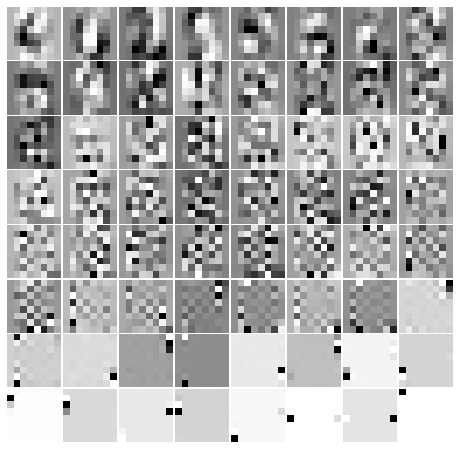

In [4]:
pca = PCA(n_components=64)
pca.fit(digits_features)
tools.display_rows_as_images(pca.components_);

## Генерация посредством усреднения цифр

Просто усредним все единицы

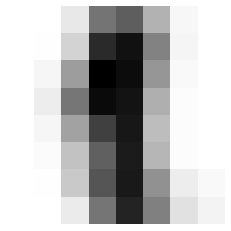

In [5]:
X_ones = digits_features[digits_labels == 1]
mean_one = np.mean(X_ones, axis = 0)
plt.imshow(mean_one.reshape(8, 8), cmap='Greys')
plt.axis(False);

Результат не очень впечатляющий. Скорее всего это происходит потому что единицы крайне сильно отличаются по написанию

## Анализ единиц

### Первичный взгляд

In [6]:
def show_ordered_images(X, rows, cols, start=0, step=1):
    fig, axis = plt.subplots(rows, cols, figsize=(10, 10))
    fig.subplots_adjust(wspace=0.025, hspace=0.025)
    for i, ax in enumerate(np.ravel(axis)):
        index = start + i * step
        ax.imshow(X[index].reshape(8, 8),
                  cmap='Greys',
                  extent=[0, 1, 0, 1])
        ax.text(0, 0, index)
        ax.axis('off')

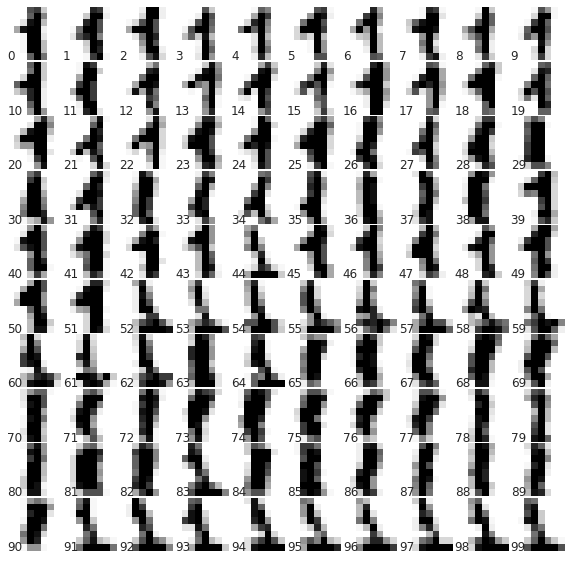

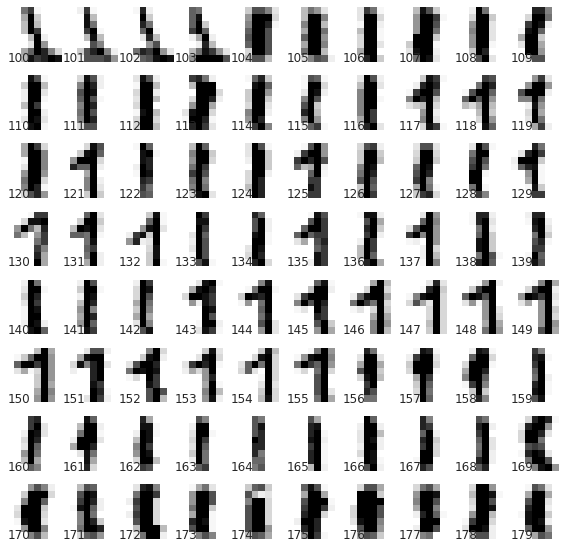

In [7]:
show_ordered_images(X_ones, 10, 10, 0, 1)
show_ordered_images(X_ones, 8, 10, 100, 1)

Из данных видно, что цифры в исходном датасете отсортированны по типу, это может облегчить процесс кластеризации цифр

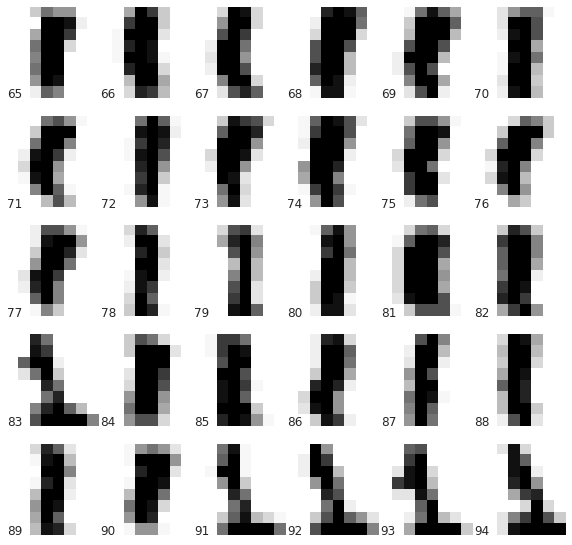

In [8]:
show_ordered_images(X_ones, 5, 6, 65, 1)

Несмотря на то что данные отсортированны мы видим, что единицы действительно очень сильно отличаются. Особенно примечательны примеры с 65 по 90

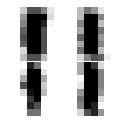

In [9]:
tools.display_rows_as_images(X_ones[[104, 105, 156, 120]]);

Также стоит отметить, что на некоторых цифрах есть что-то похожее на шумы. Их можно попробовать убрать, используя PCA

## Используем PCA для работы с странными единицами

In [10]:
def filter_noises(X, save_data=0.8):
    pca = PCA(save_data)
    pca.fit(X)
    components = pca.transform(X)
    X_filtered = pca.inverse_transform(components)
    return X_filtered

In [11]:
def plot_change_in_images(imgs_before, imgs_after):
    cols = 2
    rows = imgs_before.shape[0]
    fig, axis = plt.subplots(rows, cols, figsize=(2, 1 * rows))
    fig.subplots_adjust(wspace=0.025, hspace=0.025)
    for row in range(rows):

        axis[row, 0].imshow(imgs_before[row].reshape(8, 8),
                  cmap='Greys',
                  extent=[0, 1, 0, 1])

        axis[row, 1].imshow(imgs_after[row].reshape(8, 8),
                            cmap='Greys',
                            extent=[0, 1, 0, 1])

    axis[0, 0].set_title('Before')
    axis[0, 1].set_title('After')
    for ax in np.ravel(axis):
        ax.axis(False)
    return fig

Проверим как сработала фильтрация для наших даннных

In [12]:
def placeholder(data_saved):
    X_ones_filtered = filter_noises(X_ones, data_saved)
    img_indexes = [8, 16, 34, 75, 69, 85, 169]
    before = X_ones[img_indexes]
    after = X_ones_filtered[img_indexes]
    return plot_change_in_images(before, after)

Сравнение различных сжатий

In [13]:
import io
from PIL import Image
def buffer_plot_and_get(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    return Image.open(buf)

In [14]:
def img_to_figsize(img):
    dpi = 80
    height, width = img.size[:2]
    figsize = [2 * width / float(dpi), 2 * height / float(dpi)]
    return figsize

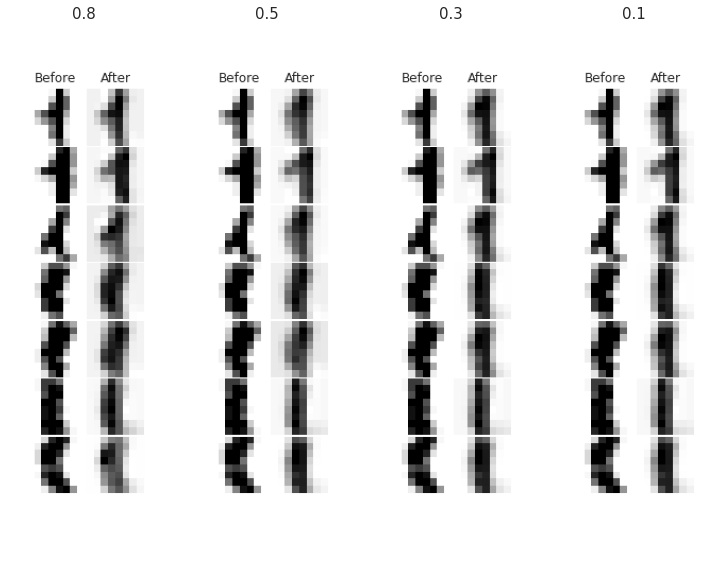

In [15]:
compressions = [0.8, 0.5, 0.3, 0.1]
fig = placeholder(0.8)
plt.close(fig)
img = buffer_plot_and_get(fig)
figsize = img_to_figsize(img)
figsize[1] *= len(compressions)

fig, axis = plt.subplots(1, len(compressions), figsize=figsize)
for ax, compress in zip(np.ravel(axis), compressions):
    fig = placeholder(compress)
    img = buffer_plot_and_get(fig)
    ax.imshow(img)
    ax.axis(False)
    ax.set_title(compress, fontsize=15)
    plt.close(fig)


Вывод: какого-либо осмысленного результата добиться не удалось

## Идентифицируем странные единицы при помощи k-means

In [16]:
from sklearn.cluster import KMeans

In [17]:
reload(tools)

<module 'extra_modules.tools' from '/home/vsevolod/Documents/python_stuff/mnist-generation-experiments/extra_modules/tools.py'>

### Посмотрим какие центры выберет Kmeans при различном количестве кластеров

In [18]:
def display_ones_centroids(n_clusters):
    kmeans = KMeans(n_clusters, random_state=100)
    kmeans.fit(X_ones)
    tools.display_rows_as_images(kmeans.cluster_centers_,  fig_multipliers=(2, 2))

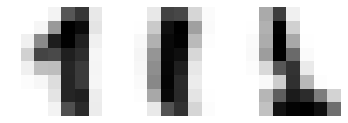

In [19]:
display_ones_centroids(3)

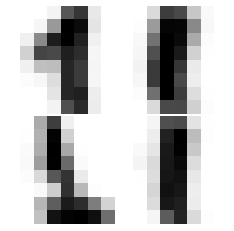

In [20]:
display_ones_centroids(4)

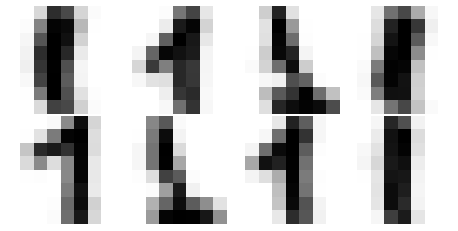

In [21]:
display_ones_centroids(8)

Вывод: наилучшим образом центры описываются при 4 кластерах, потому что в этом случае у нас присутствуют все основные классы единиц

### Рассмотри класси при количестве компонент = 4

Задачи:
1. Рассмотреть какие значения отнесены к классу странных единиц?
2. Выявить во всех классах outliers при помощи опять же kmeans

IndexError: index 50 is out of bounds for axis 0 with size 50

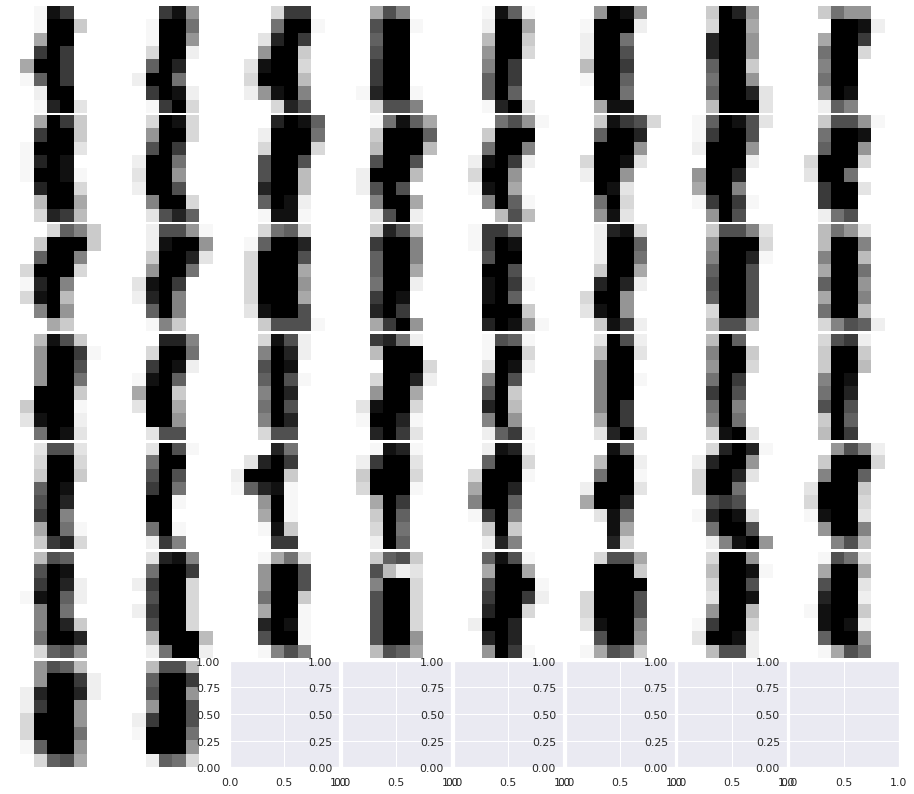

In [22]:
# Это важно, что мы здесь обозначаем RandomState!(иначе классы будут другие)
k_means_for_ones = KMeans(4, random_state=100)
k_means_for_ones.fit(X_ones)
y_k_means_ones = k_means_for_ones.predict(X_ones)
tools.display_rows_as_images(X_ones[y_k_means_ones==1], fig_multipliers=(2, 2));

Результат впечатляющий: нам удалось отобрать все странные единицы

In [23]:
def generate_random_sample(X, X_classes, good_classes=None, n_of_samples_to_mean = 2):
    if good_classes is None:
        good_classes = np.unique(X_classes)
    class_to_generate  = np.random.choice(good_classes)
    X_with_selected_class = X[X_classes == class_to_generate]
    # replace=True чтобы у нас могло быть 2 одинаковые картинки и 3-я другая
    samples_to_mean = random_choice_rows(X_with_selected_class, n_of_samples_to_mean)
    generated_sample = np.mean(samples_to_mean, axis=0)
    return generated_sample

def random_choice_rows(matrix, n_choice_rows):
    rows = matrix.shape[0]
    rows_to_choice = np.random.choice(range(rows), n_choice_rows)
    return matrix[rows_to_choice]

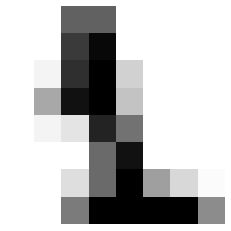

In [175]:
good_classes = [0, 2, 3]
sample = generate_random_sample(X_ones, y_k_means_ones, good_classes)
plt.imshow(sample.reshape(8, 8), cmap='Greys')
plt.axis(False)
plt.show();

# TODO Использовать для усреднеия только едницы, которые близки по евклидову расстоянию

# Иные подходы, нe связанные с усреднением

## Нейронки входят в бой

### let's build zero/one classifier

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split

prepare data

In [73]:
zero_one_mask = (digits_labels == 0) | (digits_labels == 1)
X = digits_features[zero_one_mask]
y = digits_labels[zero_one_mask][:, np.newaxis]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

model creation and validation

Epoch 1/10
18/18 [==============================] - 1s 12ms/step - loss: 2.7606 - accuracy: 0.3194 - val_loss: 2.3352 - val_accuracy: 0.2639
Epoch 2/10
18/18 [==============================] - 0s 3ms/step - loss: 1.5243 - accuracy: 0.4375 - val_loss: 1.2457 - val_accuracy: 0.5417
Epoch 3/10
18/18 [==============================] - 0s 3ms/step - loss: 0.8415 - accuracy: 0.7361 - val_loss: 0.6662 - val_accuracy: 0.8056
Epoch 4/10
18/18 [==============================] - 0s 3ms/step - loss: 0.5671 - accuracy: 0.8646 - val_loss: 0.4797 - val_accuracy: 0.8889
Epoch 5/10
18/18 [==============================] - 0s 3ms/step - loss: 0.4642 - accuracy: 0.8958 - val_loss: 0.4117 - val_accuracy: 0.9583
Epoch 6/10
18/18 [==============================] - 0s 3ms/step - loss: 0.4088 - accuracy: 0.9340 - val_loss: 0.3831 - v

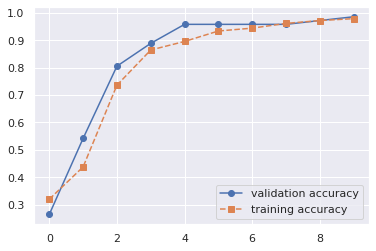

In [78]:
# построение модели
model = Sequential()
model.add(Dense(2, input_dim=64, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# компилирование модели
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# обучение модели
history = model.fit(X_train, y_train, batch_size=16, epochs=10,validation_data=(X_test, y_test),
                    shuffle=True)

# визуализайция процесса обучения
plt.plot(history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

### Генеративные нейронные сети

Я хочу сгенерировать случайный шум и использовать его как X, а картинки единиц как y. Посмотрим что из этого получится

In [116]:
rand = np.random.RandomState(42)
y = digits_features[digits_labels == 1][:100]
X = np.random.normal(y, 4)

Epoch 1/100
100/100 [==============================] - 1s 4ms/step - loss: 85962.9922 - accuracy: 0.0200 - val_loss: 379402.4688 - val_accuracy: 0.0000e+00
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 1775960.6250 - accuracy: 0.0000e+00 - val_loss: 4159062.0000 - val_accuracy: 0.0000e+00
Epoch 3/100
100/100 [==============================] - 0s 

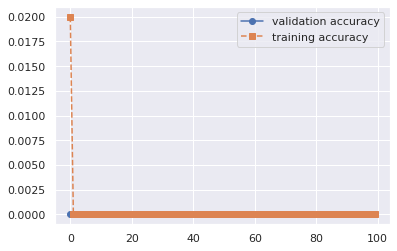

In [119]:
model = Sequential()
model.add(Dense(100, input_dim=64, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(64, activation='sigmoid'))

# компилирование модели
model.compile(loss='categorical_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])

# обучение модели
history = model.fit(X, y, batch_size=1, epochs=100, validation_data=(X, y),
                    shuffle=True)

# визуализайция процесса обучения
plt.plot(history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

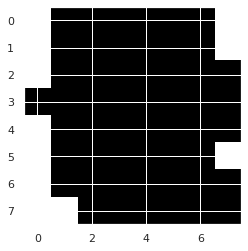

In [124]:
generated_img = model.predict(X[0].reshape(1, -1)).reshape(8, 8)
plt.imshow(generated_img, cmap='Greys')

In [125]:
generated_img

array([[0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.]], dtype=float32)